In [2]:
import datetime
from logging import exception
from multiprocessing.connection import Client
from urllib.parse import urlencode
from sqlalchemy import null
import base64 
import requests
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import numpy as np
import matplotlib.pyplot as plt

In [12]:
class SpotifyLogin(object):
    acssess_token = None
    acssess_token_expires = datetime.datetime.now()
    acsess_token_expired = True
    client_id = None
    client_secret = None
    token_url = "https://accounts.spotify.com/api/token"

#initilazes clien_id and secret
    def __init__(self,client_id,client_secret,*args,**kwargs) -> None:
        super().__init__(*args, **kwargs)
        #Just so your rember, super calls the parents, *args gets all args, **kwargs gets all keyword argumeents, so like pairs like a dict
        self.client_id = client_id
        self.client_secret = client_secret
    

    #Returns base64 encoded string(required by spotofy ig)
    def create_b64(self):
        client_id = self.client_id
        client_secret = self.client_secret
        if client_secret == None or client_id == None:
            raise exception("You did not set client_id or client_secret, or I messed up and should go back to wroking at taco bell")

        client_creds = f"{client_id}:{client_secret}"
        client_creds_b64 = base64.b64encode(client_creds.encode())
        return client_creds_b64.decode()

    def get_token_header(self):
        #returns the required header information
        client_creds_b64 = self.create_b64()
        return {
    "Authorization": f"Basic {client_creds_b64}" 
}
    def get_token_data(self):
        #returns required tokendata
        return {
    "grant_type": "client_credentials"
}

#set accsess token
    def handle_response(self,r):
         token_response_data = r.json()
         now = datetime.datetime.now()
         access_token = token_response_data['access_token'] 
         expires_in = token_response_data['expires_in'] # seconds
         expires = now + datetime.timedelta(seconds=expires_in)
         self.acssess_token_expires = expires
         self.acssess_token = access_token
         self.acsess_token_expired = expires < now

#check if valid auth
    def test_auth(self):
        token_url = self.token_url
        token_headers = self.get_token_header()
        token_data = self.get_token_data( )

        r = requests.post(token_url, data=token_data, headers=token_headers)
        valid_request = r.status_code in range(200, 299)
        if not valid_request:
            return False
        
        self.handle_response(r)
        return True

#Check if accsess toke expired
    def get_accsess_token(self):
        token = self.acssess_token
        token_expires = self.acssess_token_expires
        if token_expires < datetime.datetime.now():
            self.test_auth()
            return self.get_accsess_token
        return token

#gets searched json
    def get_link(self,_id,resource_type="albums",version='v1'):
        endpoint = f"https://api.spotify.com/{version}/{resource_type}/{_id}"
        header_thing = self.get_resource_header()
        r = requests.get(endpoint, headers=header_thing)
        if r.status_code not in range(200,299):
            return endpoint
        return r.json()


    def get_resource_header(self):
         auth_token = self.get_accsess_token()
         header = {
    "Authorization": f"Bearer {auth_token}"
}
         return header

#returns queried json
    def search_something(self,query,search_type):
        if query == None:
            raise Exception('Please enter a query')
        auth_token = self.get_accsess_token()
        header = self.get_resource_header()
        endpoint = 'https://api.spotify.com/v1/search'
        data_dict = {'q': query, 'type': search_type}
        search_data = urlencode(data_dict)
        search = f"{endpoint}?{search_data}"
        r = requests.get(search, headers=header)
        if r.status_code not in range(200,299):
            return None
        return r.json()


    def get_album(self,_id):
        return self.get_link(_id,resource_type='albums')
    def get_artist(self,_id):
        return self.get_link(_id,resource_type='artists')
    def get_track(self,_id):
        return self.get_link(_id,resource_type='tracks')
        

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from flask import Flask, url_for, session, request, redirect
import json
import time
import pandas as pd

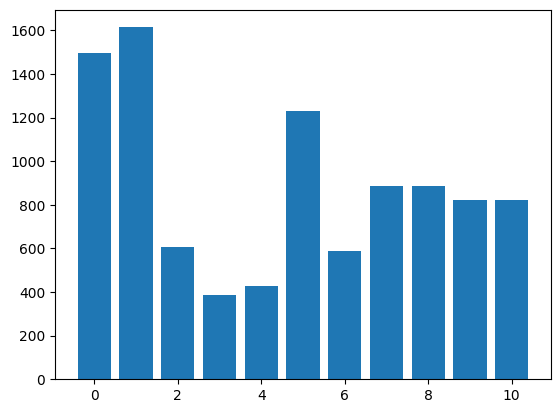

{'Donda (Deluxe)': 1497,
 'Donda': 1614,
 'JESUS IS KING': 606,
 'KIDS SEE GHOSTS': 386,
 'ye': 426,
 'The Life Of Pablo': 1232,
 'Yeezus': 587,
 'Watch The Throne (Deluxe)': 885,
 'Watch The Throne': 885,
 'My Beautiful Dark Twisted Fantasy': 822,
 'My Beautiful Dark Twisted Fantasy (Edited Version)': 822}

In [46]:
class SpotipyConnection(object):
    client_id = None
    client_secret = None
    sp = None
    def __init__(self,client_id,client_secret,*args,**kwargs) -> None:
        super().__init__(*args, **kwargs)
        #Just so your rember, super calls the parents, *args gets all args, **kwargs gets all keyword argumeents, so like pairs like a dict
        self.client_id = client_id
        self.client_secret = client_secret
        client_credentials_manager = SpotifyClientCredentials(client_id=self.client_id, client_secret=self.client_secret)
        self.sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API  

    #Gets artist id
    def get_artist_id(self,artist): 
        artist_search = self.sp.search(artist)
        itesm = artist_search.get('tracks')
        thign = itesm.get('items')
        #return (thing[0].get('artists'))[0].get('id')
        for thing in thign:
            aritst_sec = thing.get('artists')
        for element in aritst_sec:
            artist_id = element.get('id')
        return artist_id

    #This takes out deluxe, edited and explicit variations of the albums when you insert an artists discography
    def filter_albums(self,album_list):
        new_album_list = [*set(album_list)]
        for album in new_album_list:
            if (album+' (Deluxe)') in new_album_list:
                removeable_element = album+' (Deluxe)'
                new_album_list.remove(removeable_element)
            if (album+' (Edited Version)') in new_album_list:
                removeable_element = (album+' (Edited Version)')
                new_album_list.remove(removeable_element)
            if (album+' (Explicit Version)') in new_album_list:
                removeable_element = album+' (Explicit Version)'
                new_album_list.remove(removeable_element)
        return new_album_list


    def get_albums_by_artist(self,artist_id):
        artist_uri = 'spotify:artist:'+artist_id
        album_list = []
        results = self.sp.artist_albums(artist_uri, album_type='album')
        albums = results['items']
        for i in range(len(albums)):
            album_list.append(albums[i].get('name'))
        return self.filter_albums(album_list)


    def get_id(self,query,type):
        #I have to initialize this at the start of every function, how do i set it and forget it
        artist_search = self.sp.search(q=query,type=type)
        itesm = artist_search.get('tracks')
        thign = itesm.get('items')
        for thing in thign:
            aritst_sec = thing.get('artists')
        for element in aritst_sec:
            artist_id = element.get('id')
        return artist_id

#This searches for an album, gets the first one that comes up, and gets the id of each song. For some reason it doesn't give you the pop of each album in here so you have to search up each song indiviually
#As input put in your query
#mon=your album query, suht up dumb name ik
#These just sort through the the stuff that album_song_pop returns
# ugh = get_popularity(get_songs_id( get_album_song_pop('Monster')))
# Call it like that, basically gets you a list of all song ids 
    def get_album_id(self,name):
        album = self.sp.search(name,type='album',limit=1)
        return album.get('albums').get('items')[-1].get('id')

    def get_songs_id(self,album): 
        album = self.sp.album_tracks(album)
        album_songs_items = album.get('items')
        id_list= []
        for thing in album_songs_items:
            id = thing.get('id')
            id_list.append(id)
        return id_list
    def get_popularity(self,id_list):
        song_dict = []
        client = SpotifyLogin(self.client_id,self.client_secret)
        for id in id_list:
            id_info = client.get_track(id)
            song_dict.append(id_info)
            #print(id_info)
        song_dict = list(song_dict)
        return song_dict
#This gets the populartiy and names of each song, pop the value song the key
#put in list of ids from above functions
    def get_song_pop(self,album):
        pop_song_dict = {}
        pop_list = []
        song_list = []
        for thing in album:
            if (type(thing) != str):
                pop_list.append(thing.get('popularity'))
                song_list.append(thing.get('name'))
 
        for song,pop in zip(song_list,pop_list):
            pop_song_dict[song] = pop
        return pop_song_dict

#Pass in the dicionary for stats
#This will graph a interacatable hover graph with the name displauing over the thing y'know
#It shows it in the last line idk if you wanna do that
# ugh = graph_pop_songs(get_song_pop(get_popularity(get_songs_id( get_album_song_pop('Monster')))))
#this the full thing


    
    def graph_pop_albums(self,stats):
        pass

    def graph_pop_albums_full(self,artist_name):
        albums = self.get_albums_by_artist(self.get_artist_id(artist_name))
        album_pop = {}
        for album in albums:
            pop_sum = sum(self.get_song_pop(self.get_popularity(self.get_songs_id(self.get_album_id(album)))).values())
            album_pop[album] = pop_sum

        
        self.graph_pop_songs(album_pop)
        return album_pop
    
    def graph_pop_songs(self,stats):
        company=list(stats.keys())
        revenue=list(stats.values())
        fig=plt.figure()
        ax=plt.subplot()
        xpos=np.arange(len(company))
        bars = plt.bar(xpos,revenue)
        annot = ax.annotate("", xy=(5,0), xytext=(-20,20),textcoords="offset points",
                            bbox=dict(boxstyle="round", fc="black", ec="b", lw=2),
                            arrowprops=dict(arrowstyle="->"))
        annot.set_visible(False)
        def update_annot(bar):
            x = round(bar.get_x()+bar.get_width())
            y = bar.get_y()+bar.get_height()
            annot.xy=(x,y)
            x = company[x]
            text = (x,y)
            annot.set_text(text)
            annot.get_bbox_patch().set_alpha(0.4)

        def hover(event):
            vis = annot.get_visible()
            if event.inaxes == ax:
                for bar in bars:
                    cont, ind = bar.contains(event)
                    if cont:
                        update_annot(bar)
                        annot.set_visible(True)
                        fig.canvas.draw_idle()
                        return
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
        fig.canvas.mpl_connect("motion_notify_event", hover)
        plt.show()

    def graph_pop_songs_full(self,query):
        self.graph_pop_songs(self.get_song_pop(self.get_popularity(self.get_songs_id(self.get_album_id(query)))))

client_id = '4e3d2cc9dfe2450890181834312c968d'
client_secret = '4bdae51c78e84281ba04e1658a0d41f5'
thing = SpotipyConnection(client_id=client_id,client_secret=client_secret)
#thing23 = thing.rehehe('Monster')
#thing.graph_pop_songs_full('My Beautiful Dark Twisted Fantasy')
thing.graph_pop_albums_full('Kanye West')